In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Mental_Foreman/Mental_Foramen_FF.zip" -d "/content/mental_foreman"

Streaming output truncated to the last 5000 lines.
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (168).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (168).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (492).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (492).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (304).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (304).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (373).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (373).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (236).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (236).jpg  
  inflating: /content/me

In [ ]:
# Resize images

def resizeImages(resize_shape, path):
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images = np.asarray(images)
    # images = images[:,:,0]
    for i in range(1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        # print('image shape:',img.size)
        img = np.asarray(img)
        # print('image array shape:',img.shape)
        # img=img[:,:,0]
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))#3
    return images, sizes

In [ ]:
path_original = '/content/mental_foreman/Mental_Foramen_FF/ORIGINAL/'

X,X_sizes = resizeImages((256,256), path=path_original)

In [ ]:
def resizeMasks(resize_shape, path):
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images = np.asarray(images)
    # images = images[:,:,0]
    for i in range(1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        # print('image shape:',img.size)
        img = np.asarray(img)
        # print('image array shape:',img.shape)
        # img=img[:,:,0]
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images, sizes

In [ ]:
!find . -name ".DS_Store" -delete

In [ ]:
path_mask = '/content/mental_foreman/Mental_Foramen_FF/masked_images/'
Y,Y_sizes = resizeMasks((256,256), path=path_mask)

In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [ ]:
x_train=X[:500,:,:,:]
y_train=Y[:500,:,:,:]
x_test=X[500:,:,:,:]
y_test=Y[500:,:,:,:]

In [ ]:
plt.imshow(y_train[0][:,:,0])

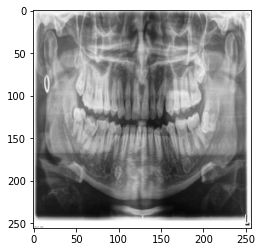

In [ ]:
plt.imshow(x_train[0])

In [ ]:
"""
ResUNet architecture in Keras TensorFlow
"""
import os
import numpy as np
import cv2

import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class ResUnet:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        def conv_block(x, n_filter):
            x_init = x

            ## Conv 1
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)
            ## Conv 2
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            ## Conv 3
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)

            ## Shortcut
            s  = Conv2D(n_filter, (1, 1), padding="same")(x_init)
            s = BatchNormalization()(s)

            ## Add
            x = Add()([x, s])
            return x

        def resnet_block(x, n_filter, pool=True):
            x1 = conv_block(x, n_filter)
            c = x1

            ## Pooling
            if pool == True:
                x = MaxPooling2D((2, 2), (2, 2))(x1)
                return c, x
            else:
                return c

        n_filters = [16, 32, 64, 96, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        ## Encoder
        c1, p1 = resnet_block(c0, n_filters[0])
        c2, p2 = resnet_block(p1, n_filters[1])
        c3, p3 = resnet_block(p2, n_filters[2])
        c4, p4 = resnet_block(p3, n_filters[3])

        ## Bridge
        b1 = resnet_block(p4, n_filters[4], pool=False)
        b2 = resnet_block(b1, n_filters[4], pool=False)

        ## Decoder
        d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
        #d1 = UpSampling2D((2, 2))(b2)
        d1 = Concatenate()([d1, c4])
        d1 = resnet_block(d1, n_filters[3], pool=False)

        d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
        #d2 = UpSampling2D((2, 2))(d1)
        d2 = Concatenate()([d2, c3])
        d2 = resnet_block(d2, n_filters[2], pool=False)

        d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
        #d3 = UpSampling2D((2, 2))(d2)
        d3 = Concatenate()([d3, c2])
        d3 = resnet_block(d3, n_filters[1], pool=False)

        d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
        #d4 = UpSampling2D((2, 2))(d3)
        d4 = Concatenate()([d4, c1])
        d4 = resnet_block(d4, n_filters[0], pool=False)

        ## output
        outputs = Conv2D(1, (1, 1), padding="same")(d4)
        outputs = BatchNormalization()(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
"""
ResUNet++ architecture in Keras TensorFlow
"""
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

class ResUnetPlusPlus:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(1, (1, 1), padding="same")(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# from data_generator import DataGen
# from unet import Unet
# from resunet import ResUnet
# from m_resunet import ResUnetPlusPlus
#from metrics import dice_coef, dice_loss


In [ ]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.2 * binary_crossentropy(y_true, y_pred) + 0.8 * dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
# © 2022 GitHub, Inc.
# Terms
# Priva

In [ ]:
image_size = 256
batch_size = 4
lr = 1e-4
# epochs = 20

arch = ResUnetPlusPlus(input_size=image_size)
model = arch.build_model() 
optimizer = Nadam(lr)
metrics = ['accuracy', Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)
callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#val_loss


In [ ]:
model.summary()

In [ ]:
# ResUnet++
model.fit(x_train,y_train,batch_size=4,epochs=200,verbose=1)

In [ ]:
image_size = 256
batch_size = 4
lr = 1e-4
kf = KFold(5, shuffle=True, random_state=42) # Use for KFold classification
oos_y = []
oos_pred = []

fold = 0
for train, test in kf.split(x_train):
    fold+=1
    print(f"Fold #{fold}")
        
    xx_train = x_train[train]
    yy_train = y_train[train]
    xx_test = x_train[test]
    yy_test = y_train[test]
    
    arch = ResUnetPlusPlus(input_size=image_size)
    model = arch.build_model() 
    optimizer = Nadam(lr)
    metrics = ['accuracy', Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
    model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)
    callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#val_loss
    
    model.fit(xx_train,yy_train,batch_size=4,epochs=200,verbose=1)
    
    pred = model.predict(x_test)
    
    oos_y.append(yy_test)
    oos_pred.append(pred)    

    # Measure this fold's Dice Score
    score = np.sqrt(dice_coef(pred,y_test))
    print(f"Fold score (Dice Score): {score}")

Fold #1
Epoch 1/200
100/100 [==============================] - 41s 214ms/step - loss: 0.9629 - accuracy: 0.8147 - recall_1: 0.9686 - precision_1: 0.0236 - dice_coef: 0.0371 - mean_io_u_1: 0.4868
Epoch 2/200
100/100 [==============================] - 22s 218ms/step - loss: 0.9177 - accuracy: 0.9557 - recall_1: 0.9525 - precision_1: 0.0958 - dice_coef: 0.0823 - mean_io_u_1: 0.4938
Epoch 3/200
100/100 [==============================] - 22s 215ms/step - loss: 0.8736 - accuracy: 0.9722 - recall_1: 0.9077 - precision_1: 0.1449 - dice_coef: 0.1264 - mean_io_u_1: 0.5073
Epoch 4/200
100/100 [==============================] - 21s 213ms/step - loss: 0.8054 - accuracy: 0.9831 - recall_1: 0.8655 - precision_1: 0.2269 - dice_coef: 0.1946 - mean_io_u_1: 0.5242
Epoch 5/200
100/100 [==============================] - 21s 215ms/step - loss: 0.6742 - accuracy: 0.9911 - recall_1: 0.7655 - precision_1: 0.3963 - dice_coef: 0.3258 - mean_io_u_1: 0.5521
Epoch 6/200
100/100 [==============================] - 21

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(dice_coef(oos_pred,oos_y))
print(f"Final average Fold score (Dice Score): {score}")

In [ ]:
# import sklearn.metrics.confusion_matrix()

In [ ]:
model.save('saved_weights/ResUnetPlusPlus.h5')

In [ ]:
predict_img = model.predict(x_test)

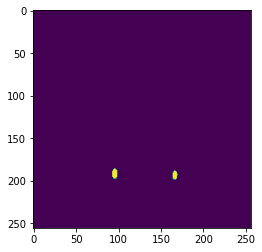

In [ ]:
plt.imshow(predict_img[7][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_img, y_test):
    dice = dice_coef(label, image)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

dice_average : tf.Tensor(0.58022696, shape=(), dtype=float32)


In [ ]:
m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_img)
print("Mean IoU :",m.result().numpy())

Mean IoU : 0.65245765


# ***ResUnet architecture***

In [ ]:
# ResUnet architecture

image_size = 256
batch_size = 4
lr = 1e-5
# epochs = 10

arch = ResUnet(input_size=image_size)
model = arch.build_model()
optimizer = Adam(lr)
metrics = ['accuracy', Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)
callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#val_loss
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 256, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

In [ ]:
model.fit(x_train,y_train,batch_size=4,epochs=200,verbose=1, callbacks=callbacks)

Epoch 1/200
125/125 [==============================] - 19s 104ms/step - loss: 0.9932 - accuracy: 0.4331 - recall_1: 0.9496 - precision_1: 0.0075 - dice_coef: 0.0068 - mean_io_u_2: 0.4995
Epoch 2/200
125/125 [==============================] - 13s 105ms/step - loss: 0.9922 - accuracy: 0.5131 - recall_1: 0.9612 - precision_1: 0.0089 - dice_coef: 0.0078 - mean_io_u_2: 0.4995
Epoch 3/200
125/125 [==============================] - 13s 103ms/step - loss: 0.9913 - accuracy: 0.5722 - recall_1: 0.9617 - precision_1: 0.0101 - dice_coef: 0.0087 - mean_io_u_2: 0.4995
Epoch 4/200
125/125 [==============================] - 13s 102ms/step - loss: 0.9906 - accuracy: 0.6025 - recall_1: 0.9790 - precision_1: 0.0110 - dice_coef: 0.0094 - mean_io_u_2: 0.4995
Epoch 5/200
125/125 [==============================] - 13s 102ms/step - loss: 0.9902 - accuracy: 0.6328 - recall_1: 0.9913 - precision_1: 0.0121 - dice_coef: 0.0098 - mean_io_u_2: 0.4995
Epoch 6/200
125/125 [==============================] - 13s 102ms/

In [ ]:
model.save('saved_weights/ResUnet.h5')

In [ ]:
# model.load_weights()

In [ ]:
predict_i = model.predict(x_test)

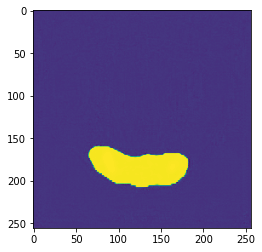

In [ ]:
plt.imshow(predict_i[90][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_i, y_test):
    # print(count)
    # print(image.shape)
    # print(label.shape)
    dice = dice_coef(label, image)
    # print(dice)
    # print(count)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_i)
print("Mean IoU :",m.result().numpy())

dice_average : tf.Tensor(0.013206023, shape=(), dtype=float32)
Mean IoU : 0.49938783


In [ ]:
!pip3 install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 5.6 MB/s 


In [ ]:
from keras_unet_collection import models, losses

# ***U-Net++***

In [ ]:
# Model: Unet++2d
num_labels = 1

model_Unet_plus = models.unet_plus_2d((256, 256, 3), filter_num=[16,32,64, 128, 256], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone=None, 
                           weights='imagenet',freeze_backbone=True, freeze_batch_norm=True,
                           name='unet_plus')

model_Unet_plus.compile(loss=dice_loss, optimizer='adam', 
              metrics=['accuracy', losses.dice_coef, Recall(), Precision(), MeanIoU(num_classes=2)])#losses.dice

print(model_Unet_plus.summary())

Model: "unet_plus_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 unet_plus_down0_0 (Conv2D)  (None, 256, 256, 16)      432       
                                                                 
 unet_plus_down0_0_bn (Batch  (None, 256, 256, 16)     64        
 Normalization)                                                  
                                                                 
 unet_plus_down0_0_activatio  (None, 256, 256, 16)     0         
 n (ReLU)                                                        
                                                                 
 unet_plus_down0_1 (Conv2D)  (None, 256, 256, 16)      2304      
                                                                 
 unet_plus_down0_1_bn (Batch  (None, 256, 256, 16) 

In [ ]:
callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#monitor='val_loss'
history = model_Unet_plus.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 4,
                    #validation_split=0.1, 
                    shuffle=False,
                    epochs=200, callbacks=callbacks)


Epoch 1/200
125/125 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.9098 - dice_coef: 0.0255 - recall: 0.8764 - precision: 0.0435 - mean_io_u: 0.5178

125/125 [==============================] - 24s 60ms/step - loss: 0.9744 - accuracy: 0.9098 - dice_coef: 0.0255 - recall: 0.8764 - precision: 0.0435 - mean_io_u: 0.5178
Epoch 2/200
125/125 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.9851 - dice_coef: 0.1248 - recall: 0.7460 - precision: 0.2296 - mean_io_u: 0.5450

125/125 [==============================] - 8s 60ms/step - loss: 0.8751 - accuracy: 0.9851 - dice_coef: 0.1248 - recall: 0.7460 - precision: 0.2296 - mean_io_u: 0.5450
Epoch 3/200
125/125 [==============================] - ETA: 0s - loss: 0.7000 - accuracy: 0.9931 - dice_coef: 0.2997 - recall: 0.4936 - precision: 0.4188 - mean_io_u: 0.5598

125/125 [==============================] - 8s 61ms/step - loss: 0.7000 - accuracy: 0.9931 - dice_coef: 0.2997 - recall: 0.4936 - precision: 0.4188 - mean_io_u: 0.5598
Epoch 4/200
125/125 [==============================] - ETA: 0s - loss: 0.7084 - accuracy: 0.9943 - dice_coef: 0.2911 - recall: 0.2978 - precision: 0.4489 - mean_io_u: 0.5550

125/125 [==============================] - 8s 61ms/step - loss: 0.7084 - accuracy: 0.9943 - dice_coef: 0.2911 - recall: 0.2978 - precision: 0.4489 - mean_io_u: 0.5550
Epoch 5/200
125/125 [==============================] - ETA: 0s - loss: 0.6710 - accuracy: 0.9945 - dice_coef: 0.3285 - recall: 0.3076 - precision: 0.4984 - mean_io_u: 0.5610

125/125 [==============================] - 8s 61ms/step - loss: 0.6710 - accuracy: 0.9945 - dice_coef: 0.3285 - recall: 0.3076 - precision: 0.4984 - mean_io_u: 0.5610
Epoch 6/200
125/125 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.9946 - dice_coef: 0.3332 - recall: 0.3043 - precision: 0.5013 - mean_io_u: 0.5614

125/125 [==============================] - 8s 61ms/step - loss: 0.6663 - accuracy: 0.9946 - dice_coef: 0.3332 - recall: 0.3043 - precision: 0.5013 - mean_io_u: 0.5614
Epoch 7/200
125/125 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.9946 - dice_coef: 0.3416 - recall: 0.3099 - precision: 0.5097 - mean_io_u: 0.5635

125/125 [==============================] - 8s 62ms/step - loss: 0.6580 - accuracy: 0.9946 - dice_coef: 0.3416 - recall: 0.3099 - precision: 0.5097 - mean_io_u: 0.5635
Epoch 8/200
125/125 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.9947 - dice_coef: 0.3484 - recall: 0.3075 - precision: 0.5252 - mean_io_u: 0.5652

125/125 [==============================] - 8s 62ms/step - loss: 0.6511 - accuracy: 0.9947 - dice_coef: 0.3484 - recall: 0.3075 - precision: 0.5252 - mean_io_u: 0.5652
Epoch 9/200
125/125 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.9947 - dice_coef: 0.3546 - recall: 0.3093 - precision: 0.5308 - mean_io_u: 0.5665

125/125 [==============================] - 8s 62ms/step - loss: 0.6450 - accuracy: 0.9947 - dice_coef: 0.3546 - recall: 0.3093 - precision: 0.5308 - mean_io_u: 0.5665
Epoch 10/200
125/125 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.9947 - dice_coef: 0.3539 - recall: 0.3091 - precision: 0.5325 - mean_io_u: 0.5663

125/125 [==============================] - 8s 62ms/step - loss: 0.6456 - accuracy: 0.9947 - dice_coef: 0.3539 - recall: 0.3091 - precision: 0.5325 - mean_io_u: 0.5663
Epoch 11/200
125/125 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.9948 - dice_coef: 0.3559 - recall: 0.3059 - precision: 0.5388 - mean_io_u: 0.5678

125/125 [==============================] - 8s 62ms/step - loss: 0.6436 - accuracy: 0.9948 - dice_coef: 0.3559 - recall: 0.3059 - precision: 0.5388 - mean_io_u: 0.5678
Epoch 12/200
125/125 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.9947 - dice_coef: 0.3573 - recall: 0.3106 - precision: 0.5370 - mean_io_u: 0.5672

125/125 [==============================] - 8s 62ms/step - loss: 0.6422 - accuracy: 0.9947 - dice_coef: 0.3573 - recall: 0.3106 - precision: 0.5370 - mean_io_u: 0.5672
Epoch 13/200
125/125 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.9949 - dice_coef: 0.3693 - recall: 0.3058 - precision: 0.5661 - mean_io_u: 0.5713

125/125 [==============================] - 8s 61ms/step - loss: 0.6302 - accuracy: 0.9949 - dice_coef: 0.3693 - recall: 0.3058 - precision: 0.5661 - mean_io_u: 0.5713
Epoch 14/200
125/125 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.9949 - dice_coef: 0.3742 - recall: 0.3151 - precision: 0.5682 - mean_io_u: 0.5722

125/125 [==============================] - 8s 61ms/step - loss: 0.6253 - accuracy: 0.9949 - dice_coef: 0.3742 - recall: 0.3151 - precision: 0.5682 - mean_io_u: 0.5722
Epoch 15/200
125/125 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.9950 - dice_coef: 0.3859 - recall: 0.3052 - precision: 0.6013 - mean_io_u: 0.5762

125/125 [==============================] - 8s 61ms/step - loss: 0.6136 - accuracy: 0.9950 - dice_coef: 0.3859 - recall: 0.3052 - precision: 0.6013 - mean_io_u: 0.5762
Epoch 16/200
125/125 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.9950 - dice_coef: 0.3901 - recall: 0.3065 - precision: 0.6060 - mean_io_u: 0.5778

125/125 [==============================] - 8s 62ms/step - loss: 0.6094 - accuracy: 0.9950 - dice_coef: 0.3901 - recall: 0.3065 - precision: 0.6060 - mean_io_u: 0.5778
Epoch 17/200
125/125 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.9951 - dice_coef: 0.3988 - recall: 0.3118 - precision: 0.6186 - mean_io_u: 0.5795

125/125 [==============================] - 8s 61ms/step - loss: 0.6007 - accuracy: 0.9951 - dice_coef: 0.3988 - recall: 0.3118 - precision: 0.6186 - mean_io_u: 0.5795
Epoch 18/200
125/125 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.9951 - dice_coef: 0.4017 - recall: 0.3134 - precision: 0.6254 - mean_io_u: 0.5811

125/125 [==============================] - 8s 61ms/step - loss: 0.5978 - accuracy: 0.9951 - dice_coef: 0.4017 - recall: 0.3134 - precision: 0.6254 - mean_io_u: 0.5811
Epoch 19/200
125/125 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.9951 - dice_coef: 0.4031 - recall: 0.3168 - precision: 0.6231 - mean_io_u: 0.5809

125/125 [==============================] - 8s 61ms/step - loss: 0.5964 - accuracy: 0.9951 - dice_coef: 0.4031 - recall: 0.3168 - precision: 0.6231 - mean_io_u: 0.5809
Epoch 20/200
125/125 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.9953 - dice_coef: 0.4237 - recall: 0.3105 - precision: 0.6700 - mean_io_u: 0.5881

125/125 [==============================] - 8s 61ms/step - loss: 0.5759 - accuracy: 0.9953 - dice_coef: 0.4237 - recall: 0.3105 - precision: 0.6700 - mean_io_u: 0.5881
Epoch 21/200
125/125 [==============================] - ETA: 0s - loss: 0.5644 - accuracy: 0.9953 - dice_coef: 0.4351 - recall: 0.3125 - precision: 0.6889 - mean_io_u: 0.5912

125/125 [==============================] - 8s 61ms/step - loss: 0.5644 - accuracy: 0.9953 - dice_coef: 0.4351 - recall: 0.3125 - precision: 0.6889 - mean_io_u: 0.5912
Epoch 22/200
125/125 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.9954 - dice_coef: 0.4421 - recall: 0.3108 - precision: 0.7036 - mean_io_u: 0.5934

125/125 [==============================] - 8s 62ms/step - loss: 0.5574 - accuracy: 0.9954 - dice_coef: 0.4421 - recall: 0.3108 - precision: 0.7036 - mean_io_u: 0.5934
Epoch 23/200
125/125 [==============================] - ETA: 0s - loss: 0.5446 - accuracy: 0.9955 - dice_coef: 0.4549 - recall: 0.3091 - precision: 0.7310 - mean_io_u: 0.5974

125/125 [==============================] - 8s 62ms/step - loss: 0.5446 - accuracy: 0.9955 - dice_coef: 0.4549 - recall: 0.3091 - precision: 0.7310 - mean_io_u: 0.5974
Epoch 24/200
125/125 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.9955 - dice_coef: 0.4527 - recall: 0.3076 - precision: 0.7324 - mean_io_u: 0.5973

125/125 [==============================] - 8s 62ms/step - loss: 0.5468 - accuracy: 0.9955 - dice_coef: 0.4527 - recall: 0.3076 - precision: 0.7324 - mean_io_u: 0.5973
Epoch 25/200
125/125 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.9955 - dice_coef: 0.4703 - recall: 0.3059 - precision: 0.7605 - mean_io_u: 0.6025

125/125 [==============================] - 8s 61ms/step - loss: 0.5292 - accuracy: 0.9955 - dice_coef: 0.4703 - recall: 0.3059 - precision: 0.7605 - mean_io_u: 0.6025
Epoch 26/200
125/125 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.9955 - dice_coef: 0.4591 - recall: 0.3097 - precision: 0.7380 - mean_io_u: 0.5986

125/125 [==============================] - 8s 61ms/step - loss: 0.5404 - accuracy: 0.9955 - dice_coef: 0.4591 - recall: 0.3097 - precision: 0.7380 - mean_io_u: 0.5986
Epoch 27/200
125/125 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.9955 - dice_coef: 0.4756 - recall: 0.3111 - precision: 0.7591 - mean_io_u: 0.6043

125/125 [==============================] - 8s 61ms/step - loss: 0.5239 - accuracy: 0.9955 - dice_coef: 0.4756 - recall: 0.3111 - precision: 0.7591 - mean_io_u: 0.6043
Epoch 28/200
125/125 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.9956 - dice_coef: 0.4829 - recall: 0.3075 - precision: 0.7820 - mean_io_u: 0.6073

125/125 [==============================] - 8s 61ms/step - loss: 0.5166 - accuracy: 0.9956 - dice_coef: 0.4829 - recall: 0.3075 - precision: 0.7820 - mean_io_u: 0.6073
Epoch 29/200
125/125 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.9956 - dice_coef: 0.4814 - recall: 0.3076 - precision: 0.7834 - mean_io_u: 0.6068

125/125 [==============================] - 8s 61ms/step - loss: 0.5182 - accuracy: 0.9956 - dice_coef: 0.4814 - recall: 0.3076 - precision: 0.7834 - mean_io_u: 0.6068
Epoch 30/200
125/125 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.9956 - dice_coef: 0.4745 - recall: 0.3112 - precision: 0.7620 - mean_io_u: 0.6037

125/125 [==============================] - 8s 61ms/step - loss: 0.5250 - accuracy: 0.9956 - dice_coef: 0.4745 - recall: 0.3112 - precision: 0.7620 - mean_io_u: 0.6037
Epoch 31/200
125/125 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.9957 - dice_coef: 0.4929 - recall: 0.3028 - precision: 0.8019 - mean_io_u: 0.6104

125/125 [==============================] - 8s 61ms/step - loss: 0.5067 - accuracy: 0.9957 - dice_coef: 0.4929 - recall: 0.3028 - precision: 0.8019 - mean_io_u: 0.6104
Epoch 32/200
125/125 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.9956 - dice_coef: 0.4844 - recall: 0.3027 - precision: 0.7868 - mean_io_u: 0.6076

125/125 [==============================] - 8s 62ms/step - loss: 0.5152 - accuracy: 0.9956 - dice_coef: 0.4844 - recall: 0.3027 - precision: 0.7868 - mean_io_u: 0.6076
Epoch 33/200
125/125 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.9956 - dice_coef: 0.4881 - recall: 0.3118 - precision: 0.7856 - mean_io_u: 0.6079

125/125 [==============================] - 8s 61ms/step - loss: 0.5114 - accuracy: 0.9956 - dice_coef: 0.4881 - recall: 0.3118 - precision: 0.7856 - mean_io_u: 0.6079
Epoch 34/200
125/125 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.9956 - dice_coef: 0.4913 - recall: 0.3070 - precision: 0.7974 - mean_io_u: 0.6093

125/125 [==============================] - 8s 61ms/step - loss: 0.5082 - accuracy: 0.9956 - dice_coef: 0.4913 - recall: 0.3070 - precision: 0.7974 - mean_io_u: 0.6093
Epoch 35/200
125/125 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.9956 - dice_coef: 0.4957 - recall: 0.3157 - precision: 0.7975 - mean_io_u: 0.6100

125/125 [==============================] - 8s 61ms/step - loss: 0.5038 - accuracy: 0.9956 - dice_coef: 0.4957 - recall: 0.3157 - precision: 0.7975 - mean_io_u: 0.6100
Epoch 36/200
125/125 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.9957 - dice_coef: 0.4963 - recall: 0.3091 - precision: 0.8056 - mean_io_u: 0.6104

125/125 [==============================] - 8s 61ms/step - loss: 0.5033 - accuracy: 0.9957 - dice_coef: 0.4963 - recall: 0.3091 - precision: 0.8056 - mean_io_u: 0.6104
Epoch 37/200
125/125 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.9957 - dice_coef: 0.5150 - recall: 0.3125 - precision: 0.8340 - mean_io_u: 0.6165

125/125 [==============================] - 8s 61ms/step - loss: 0.4846 - accuracy: 0.9957 - dice_coef: 0.5150 - recall: 0.3125 - precision: 0.8340 - mean_io_u: 0.6165
Epoch 38/200
125/125 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.9957 - dice_coef: 0.5155 - recall: 0.3059 - precision: 0.8390 - mean_io_u: 0.6169

125/125 [==============================] - 8s 61ms/step - loss: 0.4841 - accuracy: 0.9957 - dice_coef: 0.5155 - recall: 0.3059 - precision: 0.8390 - mean_io_u: 0.6169
Epoch 39/200
125/125 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.9957 - dice_coef: 0.5184 - recall: 0.3094 - precision: 0.8411 - mean_io_u: 0.6187

125/125 [==============================] - 8s 61ms/step - loss: 0.4812 - accuracy: 0.9957 - dice_coef: 0.5184 - recall: 0.3094 - precision: 0.8411 - mean_io_u: 0.6187
Epoch 40/200
125/125 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.9957 - dice_coef: 0.5204 - recall: 0.3105 - precision: 0.8411 - mean_io_u: 0.6188

125/125 [==============================] - 8s 61ms/step - loss: 0.4791 - accuracy: 0.9957 - dice_coef: 0.5204 - recall: 0.3105 - precision: 0.8411 - mean_io_u: 0.6188
Epoch 41/200
125/125 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.9957 - dice_coef: 0.5185 - recall: 0.3102 - precision: 0.8391 - mean_io_u: 0.6177

125/125 [==============================] - 8s 61ms/step - loss: 0.4810 - accuracy: 0.9957 - dice_coef: 0.5185 - recall: 0.3102 - precision: 0.8391 - mean_io_u: 0.6177
Epoch 42/200
125/125 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.9958 - dice_coef: 0.5280 - recall: 0.3084 - precision: 0.8531 - mean_io_u: 0.6213

125/125 [==============================] - 8s 61ms/step - loss: 0.4716 - accuracy: 0.9958 - dice_coef: 0.5280 - recall: 0.3084 - precision: 0.8531 - mean_io_u: 0.6213
Epoch 43/200
125/125 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.9958 - dice_coef: 0.5322 - recall: 0.3108 - precision: 0.8571 - mean_io_u: 0.6222

125/125 [==============================] - 8s 61ms/step - loss: 0.4674 - accuracy: 0.9958 - dice_coef: 0.5322 - recall: 0.3108 - precision: 0.8571 - mean_io_u: 0.6222
Epoch 44/200
125/125 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.9958 - dice_coef: 0.5368 - recall: 0.3080 - precision: 0.8687 - mean_io_u: 0.6246

125/125 [==============================] - 8s 61ms/step - loss: 0.4628 - accuracy: 0.9958 - dice_coef: 0.5368 - recall: 0.3080 - precision: 0.8687 - mean_io_u: 0.6246
Epoch 45/200
125/125 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.9958 - dice_coef: 0.5422 - recall: 0.3083 - precision: 0.8723 - mean_io_u: 0.6271

125/125 [==============================] - 8s 61ms/step - loss: 0.4574 - accuracy: 0.9958 - dice_coef: 0.5422 - recall: 0.3083 - precision: 0.8723 - mean_io_u: 0.6271
Epoch 46/200
125/125 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.9958 - dice_coef: 0.5437 - recall: 0.3114 - precision: 0.8751 - mean_io_u: 0.6261

125/125 [==============================] - 8s 61ms/step - loss: 0.4559 - accuracy: 0.9958 - dice_coef: 0.5437 - recall: 0.3114 - precision: 0.8751 - mean_io_u: 0.6261
Epoch 47/200
125/125 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.9958 - dice_coef: 0.5435 - recall: 0.3071 - precision: 0.8775 - mean_io_u: 0.6270

125/125 [==============================] - 8s 61ms/step - loss: 0.4560 - accuracy: 0.9958 - dice_coef: 0.5435 - recall: 0.3071 - precision: 0.8775 - mean_io_u: 0.6270
Epoch 48/200
125/125 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.9958 - dice_coef: 0.5420 - recall: 0.3074 - precision: 0.8757 - mean_io_u: 0.6264

125/125 [==============================] - 8s 61ms/step - loss: 0.4576 - accuracy: 0.9958 - dice_coef: 0.5420 - recall: 0.3074 - precision: 0.8757 - mean_io_u: 0.6264
Epoch 49/200
125/125 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.9958 - dice_coef: 0.5426 - recall: 0.3074 - precision: 0.8738 - mean_io_u: 0.6258

125/125 [==============================] - 8s 63ms/step - loss: 0.4570 - accuracy: 0.9958 - dice_coef: 0.5426 - recall: 0.3074 - precision: 0.8738 - mean_io_u: 0.6258
Epoch 50/200
125/125 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.9958 - dice_coef: 0.5456 - recall: 0.3135 - precision: 0.8701 - mean_io_u: 0.6267

125/125 [==============================] - 8s 61ms/step - loss: 0.4540 - accuracy: 0.9958 - dice_coef: 0.5456 - recall: 0.3135 - precision: 0.8701 - mean_io_u: 0.6267
Epoch 51/200
125/125 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.9958 - dice_coef: 0.5381 - recall: 0.3137 - precision: 0.8616 - mean_io_u: 0.6242

125/125 [==============================] - 8s 61ms/step - loss: 0.4615 - accuracy: 0.9958 - dice_coef: 0.5381 - recall: 0.3137 - precision: 0.8616 - mean_io_u: 0.6242
Epoch 52/200
125/125 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.9958 - dice_coef: 0.5475 - recall: 0.3183 - precision: 0.8636 - mean_io_u: 0.6263

125/125 [==============================] - 8s 61ms/step - loss: 0.4521 - accuracy: 0.9958 - dice_coef: 0.5475 - recall: 0.3183 - precision: 0.8636 - mean_io_u: 0.6263
Epoch 53/200
125/125 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.9958 - dice_coef: 0.5621 - recall: 0.3377 - precision: 0.8557 - mean_io_u: 0.6284

125/125 [==============================] - 8s 62ms/step - loss: 0.4375 - accuracy: 0.9958 - dice_coef: 0.5621 - recall: 0.3377 - precision: 0.8557 - mean_io_u: 0.6284
Epoch 54/200
125/125 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.9958 - dice_coef: 0.5735 - recall: 0.3441 - precision: 0.8583 - mean_io_u: 0.6310

125/125 [==============================] - 8s 61ms/step - loss: 0.4261 - accuracy: 0.9958 - dice_coef: 0.5735 - recall: 0.3441 - precision: 0.8583 - mean_io_u: 0.6310
Epoch 55/200
125/125 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.9958 - dice_coef: 0.5909 - recall: 0.3618 - precision: 0.8572 - mean_io_u: 0.6349

125/125 [==============================] - 8s 61ms/step - loss: 0.4087 - accuracy: 0.9958 - dice_coef: 0.5909 - recall: 0.3618 - precision: 0.8572 - mean_io_u: 0.6349
Epoch 56/200
125/125 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.9958 - dice_coef: 0.5968 - recall: 0.3855 - precision: 0.8318 - mean_io_u: 0.6332

125/125 [==============================] - 8s 61ms/step - loss: 0.4029 - accuracy: 0.9958 - dice_coef: 0.5968 - recall: 0.3855 - precision: 0.8318 - mean_io_u: 0.6332
Epoch 57/200
125/125 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.9958 - dice_coef: 0.6163 - recall: 0.4040 - precision: 0.8375 - mean_io_u: 0.6377

125/125 [==============================] - 8s 61ms/step - loss: 0.3833 - accuracy: 0.9958 - dice_coef: 0.6163 - recall: 0.4040 - precision: 0.8375 - mean_io_u: 0.6377
Epoch 58/200
125/125 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.9958 - dice_coef: 0.6245 - recall: 0.4127 - precision: 0.8414 - mean_io_u: 0.6401

125/125 [==============================] - 8s 61ms/step - loss: 0.3752 - accuracy: 0.9958 - dice_coef: 0.6245 - recall: 0.4127 - precision: 0.8414 - mean_io_u: 0.6401
Epoch 59/200
125/125 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.9959 - dice_coef: 0.6403 - recall: 0.4275 - precision: 0.8517 - mean_io_u: 0.6440

125/125 [==============================] - 8s 62ms/step - loss: 0.3594 - accuracy: 0.9959 - dice_coef: 0.6403 - recall: 0.4275 - precision: 0.8517 - mean_io_u: 0.6440
Epoch 60/200
125/125 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.9959 - dice_coef: 0.6575 - recall: 0.4411 - precision: 0.8585 - mean_io_u: 0.6478

125/125 [==============================] - 8s 61ms/step - loss: 0.3422 - accuracy: 0.9959 - dice_coef: 0.6575 - recall: 0.4411 - precision: 0.8585 - mean_io_u: 0.6478
Epoch 61/200
125/125 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.9960 - dice_coef: 0.6789 - recall: 0.4471 - precision: 0.8693 - mean_io_u: 0.6535

125/125 [==============================] - 8s 61ms/step - loss: 0.3208 - accuracy: 0.9960 - dice_coef: 0.6789 - recall: 0.4471 - precision: 0.8693 - mean_io_u: 0.6535
Epoch 62/200
125/125 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.9960 - dice_coef: 0.6967 - recall: 0.4503 - precision: 0.8886 - mean_io_u: 0.6613

125/125 [==============================] - 8s 61ms/step - loss: 0.3030 - accuracy: 0.9960 - dice_coef: 0.6967 - recall: 0.4503 - precision: 0.8886 - mean_io_u: 0.6613
Epoch 63/200
125/125 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.9960 - dice_coef: 0.6997 - recall: 0.4609 - precision: 0.8866 - mean_io_u: 0.6617

125/125 [==============================] - 8s 62ms/step - loss: 0.3000 - accuracy: 0.9960 - dice_coef: 0.6997 - recall: 0.4609 - precision: 0.8866 - mean_io_u: 0.6617
Epoch 64/200
125/125 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9961 - dice_coef: 0.7149 - recall: 0.4651 - precision: 0.8963 - mean_io_u: 0.6665

125/125 [==============================] - 8s 61ms/step - loss: 0.2848 - accuracy: 0.9961 - dice_coef: 0.7149 - recall: 0.4651 - precision: 0.8963 - mean_io_u: 0.6665
Epoch 65/200
125/125 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.9961 - dice_coef: 0.7241 - recall: 0.4648 - precision: 0.9062 - mean_io_u: 0.6680

125/125 [==============================] - 8s 63ms/step - loss: 0.2757 - accuracy: 0.9961 - dice_coef: 0.7241 - recall: 0.4648 - precision: 0.9062 - mean_io_u: 0.6680
Epoch 66/200
125/125 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9961 - dice_coef: 0.7318 - recall: 0.4761 - precision: 0.9083 - mean_io_u: 0.6702

125/125 [==============================] - 8s 61ms/step - loss: 0.2680 - accuracy: 0.9961 - dice_coef: 0.7318 - recall: 0.4761 - precision: 0.9083 - mean_io_u: 0.6702
Epoch 67/200
125/125 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9961 - dice_coef: 0.7312 - recall: 0.4810 - precision: 0.9029 - mean_io_u: 0.6705

125/125 [==============================] - 8s 61ms/step - loss: 0.2686 - accuracy: 0.9961 - dice_coef: 0.7312 - recall: 0.4810 - precision: 0.9029 - mean_io_u: 0.6705
Epoch 68/200
125/125 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.9962 - dice_coef: 0.7453 - recall: 0.4676 - precision: 0.9214 - mean_io_u: 0.6763

125/125 [==============================] - 8s 61ms/step - loss: 0.2545 - accuracy: 0.9962 - dice_coef: 0.7453 - recall: 0.4676 - precision: 0.9214 - mean_io_u: 0.6763
Epoch 69/200
125/125 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9962 - dice_coef: 0.7427 - recall: 0.4794 - precision: 0.9115 - mean_io_u: 0.6745

125/125 [==============================] - 8s 61ms/step - loss: 0.2571 - accuracy: 0.9962 - dice_coef: 0.7427 - recall: 0.4794 - precision: 0.9115 - mean_io_u: 0.6745
Epoch 70/200
125/125 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9962 - dice_coef: 0.7410 - recall: 0.4771 - precision: 0.9132 - mean_io_u: 0.6734

125/125 [==============================] - 8s 62ms/step - loss: 0.2588 - accuracy: 0.9962 - dice_coef: 0.7410 - recall: 0.4771 - precision: 0.9132 - mean_io_u: 0.6734
Epoch 71/200
125/125 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9961 - dice_coef: 0.7366 - recall: 0.4775 - precision: 0.9105 - mean_io_u: 0.6717

125/125 [==============================] - 8s 61ms/step - loss: 0.2632 - accuracy: 0.9961 - dice_coef: 0.7366 - recall: 0.4775 - precision: 0.9105 - mean_io_u: 0.6717
Epoch 72/200
125/125 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9961 - dice_coef: 0.7367 - recall: 0.4759 - precision: 0.9118 - mean_io_u: 0.6722

125/125 [==============================] - 8s 61ms/step - loss: 0.2631 - accuracy: 0.9961 - dice_coef: 0.7367 - recall: 0.4759 - precision: 0.9118 - mean_io_u: 0.6722
Epoch 73/200
125/125 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9962 - dice_coef: 0.7464 - recall: 0.4754 - precision: 0.9200 - mean_io_u: 0.6751

125/125 [==============================] - 8s 61ms/step - loss: 0.2534 - accuracy: 0.9962 - dice_coef: 0.7464 - recall: 0.4754 - precision: 0.9200 - mean_io_u: 0.6751
Epoch 74/200
125/125 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9962 - dice_coef: 0.7527 - recall: 0.4784 - precision: 0.9238 - mean_io_u: 0.6776

125/125 [==============================] - 8s 61ms/step - loss: 0.2471 - accuracy: 0.9962 - dice_coef: 0.7527 - recall: 0.4784 - precision: 0.9238 - mean_io_u: 0.6776
Epoch 75/200
125/125 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9962 - dice_coef: 0.7550 - recall: 0.4807 - precision: 0.9247 - mean_io_u: 0.6785

125/125 [==============================] - 8s 61ms/step - loss: 0.2448 - accuracy: 0.9962 - dice_coef: 0.7550 - recall: 0.4807 - precision: 0.9247 - mean_io_u: 0.6785
Epoch 76/200
125/125 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9962 - dice_coef: 0.7588 - recall: 0.4788 - precision: 0.9270 - mean_io_u: 0.6799

125/125 [==============================] - 8s 61ms/step - loss: 0.2410 - accuracy: 0.9962 - dice_coef: 0.7588 - recall: 0.4788 - precision: 0.9270 - mean_io_u: 0.6799
Epoch 77/200
125/125 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9962 - dice_coef: 0.7632 - recall: 0.4812 - precision: 0.9303 - mean_io_u: 0.6820

125/125 [==============================] - 8s 62ms/step - loss: 0.2366 - accuracy: 0.9962 - dice_coef: 0.7632 - recall: 0.4812 - precision: 0.9303 - mean_io_u: 0.6820
Epoch 78/200
125/125 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9962 - dice_coef: 0.7610 - recall: 0.4829 - precision: 0.9275 - mean_io_u: 0.6807

125/125 [==============================] - 8s 61ms/step - loss: 0.2388 - accuracy: 0.9962 - dice_coef: 0.7610 - recall: 0.4829 - precision: 0.9275 - mean_io_u: 0.6807
Epoch 79/200
125/125 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9962 - dice_coef: 0.7693 - recall: 0.4828 - precision: 0.9336 - mean_io_u: 0.6843

125/125 [==============================] - 8s 62ms/step - loss: 0.2306 - accuracy: 0.9962 - dice_coef: 0.7693 - recall: 0.4828 - precision: 0.9336 - mean_io_u: 0.6843
Epoch 80/200
125/125 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9962 - dice_coef: 0.7757 - recall: 0.4871 - precision: 0.9380 - mean_io_u: 0.6864

125/125 [==============================] - 8s 61ms/step - loss: 0.2242 - accuracy: 0.9962 - dice_coef: 0.7757 - recall: 0.4871 - precision: 0.9380 - mean_io_u: 0.6864
Epoch 81/200
125/125 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9963 - dice_coef: 0.7770 - recall: 0.4869 - precision: 0.9374 - mean_io_u: 0.6870

125/125 [==============================] - 8s 63ms/step - loss: 0.2228 - accuracy: 0.9963 - dice_coef: 0.7770 - recall: 0.4869 - precision: 0.9374 - mean_io_u: 0.6870
Epoch 82/200
125/125 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9963 - dice_coef: 0.7792 - recall: 0.4855 - precision: 0.9395 - mean_io_u: 0.6870

125/125 [==============================] - 8s 61ms/step - loss: 0.2206 - accuracy: 0.9963 - dice_coef: 0.7792 - recall: 0.4855 - precision: 0.9395 - mean_io_u: 0.6870
Epoch 83/200
125/125 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9963 - dice_coef: 0.7794 - recall: 0.4874 - precision: 0.9398 - mean_io_u: 0.6860

125/125 [==============================] - 8s 61ms/step - loss: 0.2205 - accuracy: 0.9963 - dice_coef: 0.7794 - recall: 0.4874 - precision: 0.9398 - mean_io_u: 0.6860
Epoch 84/200
125/125 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9963 - dice_coef: 0.7809 - recall: 0.4877 - precision: 0.9409 - mean_io_u: 0.6872

125/125 [==============================] - 8s 61ms/step - loss: 0.2189 - accuracy: 0.9963 - dice_coef: 0.7809 - recall: 0.4877 - precision: 0.9409 - mean_io_u: 0.6872
Epoch 85/200
125/125 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9963 - dice_coef: 0.7791 - recall: 0.4853 - precision: 0.9406 - mean_io_u: 0.6862

125/125 [==============================] - 8s 61ms/step - loss: 0.2208 - accuracy: 0.9963 - dice_coef: 0.7791 - recall: 0.4853 - precision: 0.9406 - mean_io_u: 0.6862
Epoch 86/200
125/125 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9962 - dice_coef: 0.7711 - recall: 0.4899 - precision: 0.9314 - mean_io_u: 0.6828

125/125 [==============================] - 8s 62ms/step - loss: 0.2287 - accuracy: 0.9962 - dice_coef: 0.7711 - recall: 0.4899 - precision: 0.9314 - mean_io_u: 0.6828
Epoch 87/200
125/125 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9962 - dice_coef: 0.7748 - recall: 0.4879 - precision: 0.9349 - mean_io_u: 0.6837

125/125 [==============================] - 8s 61ms/step - loss: 0.2250 - accuracy: 0.9962 - dice_coef: 0.7748 - recall: 0.4879 - precision: 0.9349 - mean_io_u: 0.6837
Epoch 88/200
125/125 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9962 - dice_coef: 0.7714 - recall: 0.4873 - precision: 0.9319 - mean_io_u: 0.6831

125/125 [==============================] - 8s 61ms/step - loss: 0.2284 - accuracy: 0.9962 - dice_coef: 0.7714 - recall: 0.4873 - precision: 0.9319 - mean_io_u: 0.6831
Epoch 89/200
125/125 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9963 - dice_coef: 0.7814 - recall: 0.4953 - precision: 0.9379 - mean_io_u: 0.6867

125/125 [==============================] - 8s 62ms/step - loss: 0.2184 - accuracy: 0.9963 - dice_coef: 0.7814 - recall: 0.4953 - precision: 0.9379 - mean_io_u: 0.6867
Epoch 90/200
125/125 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9963 - dice_coef: 0.7829 - recall: 0.4883 - precision: 0.9422 - mean_io_u: 0.6868

125/125 [==============================] - 8s 61ms/step - loss: 0.2169 - accuracy: 0.9963 - dice_coef: 0.7829 - recall: 0.4883 - precision: 0.9422 - mean_io_u: 0.6868
Epoch 91/200
125/125 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9963 - dice_coef: 0.7880 - recall: 0.4929 - precision: 0.9429 - mean_io_u: 0.6884

125/125 [==============================] - 8s 62ms/step - loss: 0.2118 - accuracy: 0.9963 - dice_coef: 0.7880 - recall: 0.4929 - precision: 0.9429 - mean_io_u: 0.6884
Epoch 92/200
125/125 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9963 - dice_coef: 0.7983 - recall: 0.4905 - precision: 0.9538 - mean_io_u: 0.6941

125/125 [==============================] - 8s 61ms/step - loss: 0.2015 - accuracy: 0.9963 - dice_coef: 0.7983 - recall: 0.4905 - precision: 0.9538 - mean_io_u: 0.6941
Epoch 93/200
125/125 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9963 - dice_coef: 0.7997 - recall: 0.4895 - precision: 0.9542 - mean_io_u: 0.6950

125/125 [==============================] - 8s 62ms/step - loss: 0.2002 - accuracy: 0.9963 - dice_coef: 0.7997 - recall: 0.4895 - precision: 0.9542 - mean_io_u: 0.6950
Epoch 94/200
125/125 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.9963 - dice_coef: 0.8005 - recall: 0.4905 - precision: 0.9562 - mean_io_u: 0.6939

125/125 [==============================] - 8s 61ms/step - loss: 0.1993 - accuracy: 0.9963 - dice_coef: 0.8005 - recall: 0.4905 - precision: 0.9562 - mean_io_u: 0.6939
Epoch 95/200
125/125 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9963 - dice_coef: 0.8081 - recall: 0.4920 - precision: 0.9610 - mean_io_u: 0.6970

125/125 [==============================] - 8s 61ms/step - loss: 0.1917 - accuracy: 0.9963 - dice_coef: 0.8081 - recall: 0.4920 - precision: 0.9610 - mean_io_u: 0.6970
Epoch 96/200
125/125 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9963 - dice_coef: 0.8046 - recall: 0.4950 - precision: 0.9563 - mean_io_u: 0.6963

125/125 [==============================] - 8s 61ms/step - loss: 0.1952 - accuracy: 0.9963 - dice_coef: 0.8046 - recall: 0.4950 - precision: 0.9563 - mean_io_u: 0.6963
Epoch 97/200
125/125 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9963 - dice_coef: 0.8034 - recall: 0.4940 - precision: 0.9547 - mean_io_u: 0.6960

125/125 [==============================] - 8s 63ms/step - loss: 0.1964 - accuracy: 0.9963 - dice_coef: 0.8034 - recall: 0.4940 - precision: 0.9547 - mean_io_u: 0.6960
Epoch 98/200
125/125 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9963 - dice_coef: 0.8044 - recall: 0.4935 - precision: 0.9572 - mean_io_u: 0.6955

125/125 [==============================] - 8s 61ms/step - loss: 0.1955 - accuracy: 0.9963 - dice_coef: 0.8044 - recall: 0.4935 - precision: 0.9572 - mean_io_u: 0.6955
Epoch 99/200
125/125 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9963 - dice_coef: 0.8042 - recall: 0.4921 - precision: 0.9584 - mean_io_u: 0.6959

125/125 [==============================] - 8s 61ms/step - loss: 0.1956 - accuracy: 0.9963 - dice_coef: 0.8042 - recall: 0.4921 - precision: 0.9584 - mean_io_u: 0.6959
Epoch 100/200
125/125 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9963 - dice_coef: 0.7980 - recall: 0.4946 - precision: 0.9493 - mean_io_u: 0.6928

125/125 [==============================] - 8s 61ms/step - loss: 0.2018 - accuracy: 0.9963 - dice_coef: 0.7980 - recall: 0.4946 - precision: 0.9493 - mean_io_u: 0.6928
Epoch 101/200
125/125 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9963 - dice_coef: 0.7957 - recall: 0.4925 - precision: 0.9485 - mean_io_u: 0.6914

125/125 [==============================] - 8s 62ms/step - loss: 0.2042 - accuracy: 0.9963 - dice_coef: 0.7957 - recall: 0.4925 - precision: 0.9485 - mean_io_u: 0.6914
Epoch 102/200
125/125 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9963 - dice_coef: 0.8043 - recall: 0.4936 - precision: 0.9563 - mean_io_u: 0.6955

125/125 [==============================] - 8s 61ms/step - loss: 0.1956 - accuracy: 0.9963 - dice_coef: 0.8043 - recall: 0.4936 - precision: 0.9563 - mean_io_u: 0.6955
Epoch 103/200
125/125 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9963 - dice_coef: 0.8015 - recall: 0.4943 - precision: 0.9539 - mean_io_u: 0.6939

125/125 [==============================] - 8s 61ms/step - loss: 0.1984 - accuracy: 0.9963 - dice_coef: 0.8015 - recall: 0.4943 - precision: 0.9539 - mean_io_u: 0.6939
Epoch 104/200
125/125 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9963 - dice_coef: 0.7992 - recall: 0.4942 - precision: 0.9522 - mean_io_u: 0.6935

125/125 [==============================] - 8s 61ms/step - loss: 0.2007 - accuracy: 0.9963 - dice_coef: 0.7992 - recall: 0.4942 - precision: 0.9522 - mean_io_u: 0.6935
Epoch 105/200
125/125 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9963 - dice_coef: 0.8022 - recall: 0.4927 - precision: 0.9556 - mean_io_u: 0.6943

125/125 [==============================] - 8s 62ms/step - loss: 0.1976 - accuracy: 0.9963 - dice_coef: 0.8022 - recall: 0.4927 - precision: 0.9556 - mean_io_u: 0.6943
Epoch 106/200
125/125 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9963 - dice_coef: 0.8060 - recall: 0.4991 - precision: 0.9566 - mean_io_u: 0.6961

125/125 [==============================] - 8s 61ms/step - loss: 0.1938 - accuracy: 0.9963 - dice_coef: 0.8060 - recall: 0.4991 - precision: 0.9566 - mean_io_u: 0.6961
Epoch 107/200
125/125 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9963 - dice_coef: 0.8095 - recall: 0.4928 - precision: 0.9627 - mean_io_u: 0.6973

125/125 [==============================] - 8s 62ms/step - loss: 0.1903 - accuracy: 0.9963 - dice_coef: 0.8095 - recall: 0.4928 - precision: 0.9627 - mean_io_u: 0.6973
Epoch 108/200
125/125 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9964 - dice_coef: 0.8169 - recall: 0.4999 - precision: 0.9648 - mean_io_u: 0.7006

125/125 [==============================] - 8s 62ms/step - loss: 0.1829 - accuracy: 0.9964 - dice_coef: 0.8169 - recall: 0.4999 - precision: 0.9648 - mean_io_u: 0.7006
Epoch 109/200
125/125 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9964 - dice_coef: 0.8143 - recall: 0.4947 - precision: 0.9639 - mean_io_u: 0.6999

125/125 [==============================] - 8s 61ms/step - loss: 0.1856 - accuracy: 0.9964 - dice_coef: 0.8143 - recall: 0.4947 - precision: 0.9639 - mean_io_u: 0.6999
Epoch 110/200
125/125 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9963 - dice_coef: 0.8094 - recall: 0.5009 - precision: 0.9581 - mean_io_u: 0.6967

125/125 [==============================] - 8s 62ms/step - loss: 0.1904 - accuracy: 0.9963 - dice_coef: 0.8094 - recall: 0.5009 - precision: 0.9581 - mean_io_u: 0.6967
Epoch 111/200
125/125 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9963 - dice_coef: 0.8120 - recall: 0.5006 - precision: 0.9603 - mean_io_u: 0.6981

125/125 [==============================] - 8s 62ms/step - loss: 0.1878 - accuracy: 0.9963 - dice_coef: 0.8120 - recall: 0.5006 - precision: 0.9603 - mean_io_u: 0.6981
Epoch 112/200
125/125 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9964 - dice_coef: 0.8178 - recall: 0.4970 - precision: 0.9668 - mean_io_u: 0.7009

125/125 [==============================] - 8s 61ms/step - loss: 0.1821 - accuracy: 0.9964 - dice_coef: 0.8178 - recall: 0.4970 - precision: 0.9668 - mean_io_u: 0.7009
Epoch 113/200
125/125 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9964 - dice_coef: 0.8167 - recall: 0.4955 - precision: 0.9650 - mean_io_u: 0.7007

125/125 [==============================] - 8s 63ms/step - loss: 0.1831 - accuracy: 0.9964 - dice_coef: 0.8167 - recall: 0.4955 - precision: 0.9650 - mean_io_u: 0.7007
Epoch 114/200
125/125 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9964 - dice_coef: 0.8165 - recall: 0.4993 - precision: 0.9618 - mean_io_u: 0.6996

125/125 [==============================] - 8s 62ms/step - loss: 0.1834 - accuracy: 0.9964 - dice_coef: 0.8165 - recall: 0.4993 - precision: 0.9618 - mean_io_u: 0.6996
Epoch 115/200
125/125 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9964 - dice_coef: 0.8149 - recall: 0.4975 - precision: 0.9640 - mean_io_u: 0.6995

125/125 [==============================] - 8s 61ms/step - loss: 0.1849 - accuracy: 0.9964 - dice_coef: 0.8149 - recall: 0.4975 - precision: 0.9640 - mean_io_u: 0.6995
Epoch 116/200
125/125 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9964 - dice_coef: 0.8153 - recall: 0.4971 - precision: 0.9643 - mean_io_u: 0.6997

125/125 [==============================] - 8s 62ms/step - loss: 0.1846 - accuracy: 0.9964 - dice_coef: 0.8153 - recall: 0.4971 - precision: 0.9643 - mean_io_u: 0.6997
Epoch 117/200
125/125 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9964 - dice_coef: 0.8177 - recall: 0.4997 - precision: 0.9637 - mean_io_u: 0.6992

125/125 [==============================] - 8s 61ms/step - loss: 0.1822 - accuracy: 0.9964 - dice_coef: 0.8177 - recall: 0.4997 - precision: 0.9637 - mean_io_u: 0.6992
Epoch 118/200
125/125 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9964 - dice_coef: 0.8225 - recall: 0.5008 - precision: 0.9681 - mean_io_u: 0.7021

125/125 [==============================] - 8s 62ms/step - loss: 0.1774 - accuracy: 0.9964 - dice_coef: 0.8225 - recall: 0.5008 - precision: 0.9681 - mean_io_u: 0.7021
Epoch 119/200
125/125 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9964 - dice_coef: 0.8258 - recall: 0.5040 - precision: 0.9688 - mean_io_u: 0.7032

125/125 [==============================] - 8s 61ms/step - loss: 0.1741 - accuracy: 0.9964 - dice_coef: 0.8258 - recall: 0.5040 - precision: 0.9688 - mean_io_u: 0.7032
Epoch 120/200
125/125 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9964 - dice_coef: 0.8293 - recall: 0.4993 - precision: 0.9733 - mean_io_u: 0.7049

125/125 [==============================] - 8s 62ms/step - loss: 0.1706 - accuracy: 0.9964 - dice_coef: 0.8293 - recall: 0.4993 - precision: 0.9733 - mean_io_u: 0.7049
Epoch 121/200
125/125 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9964 - dice_coef: 0.8253 - recall: 0.4935 - precision: 0.9714 - mean_io_u: 0.7037

125/125 [==============================] - 8s 62ms/step - loss: 0.1745 - accuracy: 0.9964 - dice_coef: 0.8253 - recall: 0.4935 - precision: 0.9714 - mean_io_u: 0.7037
Epoch 122/200
125/125 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9964 - dice_coef: 0.8284 - recall: 0.5023 - precision: 0.9722 - mean_io_u: 0.7034

125/125 [==============================] - 8s 62ms/step - loss: 0.1715 - accuracy: 0.9964 - dice_coef: 0.8284 - recall: 0.5023 - precision: 0.9722 - mean_io_u: 0.7034
Epoch 123/200
125/125 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9964 - dice_coef: 0.8266 - recall: 0.4992 - precision: 0.9714 - mean_io_u: 0.7033

125/125 [==============================] - 8s 62ms/step - loss: 0.1732 - accuracy: 0.9964 - dice_coef: 0.8266 - recall: 0.4992 - precision: 0.9714 - mean_io_u: 0.7033
Epoch 124/200
125/125 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9964 - dice_coef: 0.8266 - recall: 0.4996 - precision: 0.9698 - mean_io_u: 0.7033

125/125 [==============================] - 8s 61ms/step - loss: 0.1733 - accuracy: 0.9964 - dice_coef: 0.8266 - recall: 0.4996 - precision: 0.9698 - mean_io_u: 0.7033
Epoch 125/200
125/125 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9964 - dice_coef: 0.8246 - recall: 0.5028 - precision: 0.9659 - mean_io_u: 0.7024

125/125 [==============================] - 8s 62ms/step - loss: 0.1752 - accuracy: 0.9964 - dice_coef: 0.8246 - recall: 0.5028 - precision: 0.9659 - mean_io_u: 0.7024
Epoch 126/200
125/125 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9964 - dice_coef: 0.8263 - recall: 0.5042 - precision: 0.9680 - mean_io_u: 0.7027

125/125 [==============================] - 8s 61ms/step - loss: 0.1736 - accuracy: 0.9964 - dice_coef: 0.8263 - recall: 0.5042 - precision: 0.9680 - mean_io_u: 0.7027
Epoch 127/200
125/125 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9964 - dice_coef: 0.8240 - recall: 0.5038 - precision: 0.9675 - mean_io_u: 0.7010

125/125 [==============================] - 8s 62ms/step - loss: 0.1758 - accuracy: 0.9964 - dice_coef: 0.8240 - recall: 0.5038 - precision: 0.9675 - mean_io_u: 0.7010
Epoch 128/200
125/125 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9964 - dice_coef: 0.8319 - recall: 0.5020 - precision: 0.9751 - mean_io_u: 0.7056

125/125 [==============================] - 8s 62ms/step - loss: 0.1680 - accuracy: 0.9964 - dice_coef: 0.8319 - recall: 0.5020 - precision: 0.9751 - mean_io_u: 0.7056
Epoch 129/200
125/125 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9964 - dice_coef: 0.8295 - recall: 0.5065 - precision: 0.9710 - mean_io_u: 0.7041

125/125 [==============================] - 8s 63ms/step - loss: 0.1703 - accuracy: 0.9964 - dice_coef: 0.8295 - recall: 0.5065 - precision: 0.9710 - mean_io_u: 0.7041
Epoch 130/200
125/125 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9964 - dice_coef: 0.8294 - recall: 0.5041 - precision: 0.9713 - mean_io_u: 0.7041

125/125 [==============================] - 8s 62ms/step - loss: 0.1704 - accuracy: 0.9964 - dice_coef: 0.8294 - recall: 0.5041 - precision: 0.9713 - mean_io_u: 0.7041
Epoch 131/200
125/125 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9964 - dice_coef: 0.8258 - recall: 0.5015 - precision: 0.9692 - mean_io_u: 0.7035

125/125 [==============================] - 8s 62ms/step - loss: 0.1741 - accuracy: 0.9964 - dice_coef: 0.8258 - recall: 0.5015 - precision: 0.9692 - mean_io_u: 0.7035
Epoch 132/200
125/125 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9964 - dice_coef: 0.8192 - recall: 0.5011 - precision: 0.9664 - mean_io_u: 0.7000

125/125 [==============================] - 8s 62ms/step - loss: 0.1807 - accuracy: 0.9964 - dice_coef: 0.8192 - recall: 0.5011 - precision: 0.9664 - mean_io_u: 0.7000
Epoch 133/200
125/125 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9964 - dice_coef: 0.8249 - recall: 0.5009 - precision: 0.9692 - mean_io_u: 0.7020

125/125 [==============================] - 8s 62ms/step - loss: 0.1749 - accuracy: 0.9964 - dice_coef: 0.8249 - recall: 0.5009 - precision: 0.9692 - mean_io_u: 0.7020
Epoch 134/200
125/125 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9964 - dice_coef: 0.8236 - recall: 0.5041 - precision: 0.9664 - mean_io_u: 0.7021

125/125 [==============================] - 8s 62ms/step - loss: 0.1762 - accuracy: 0.9964 - dice_coef: 0.8236 - recall: 0.5041 - precision: 0.9664 - mean_io_u: 0.7021
Epoch 135/200
125/125 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9964 - dice_coef: 0.8304 - recall: 0.5017 - precision: 0.9714 - mean_io_u: 0.7052

125/125 [==============================] - 8s 61ms/step - loss: 0.1695 - accuracy: 0.9964 - dice_coef: 0.8304 - recall: 0.5017 - precision: 0.9714 - mean_io_u: 0.7052
Epoch 136/200
125/125 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9964 - dice_coef: 0.8291 - recall: 0.5067 - precision: 0.9692 - mean_io_u: 0.7031

125/125 [==============================] - 8s 62ms/step - loss: 0.1707 - accuracy: 0.9964 - dice_coef: 0.8291 - recall: 0.5067 - precision: 0.9692 - mean_io_u: 0.7031
Epoch 137/200
125/125 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9964 - dice_coef: 0.8264 - recall: 0.4996 - precision: 0.9697 - mean_io_u: 0.7025

125/125 [==============================] - 8s 62ms/step - loss: 0.1734 - accuracy: 0.9964 - dice_coef: 0.8264 - recall: 0.4996 - precision: 0.9697 - mean_io_u: 0.7025
Epoch 138/200
125/125 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9964 - dice_coef: 0.8295 - recall: 0.5033 - precision: 0.9705 - mean_io_u: 0.7032

125/125 [==============================] - 8s 62ms/step - loss: 0.1704 - accuracy: 0.9964 - dice_coef: 0.8295 - recall: 0.5033 - precision: 0.9705 - mean_io_u: 0.7032
Epoch 139/200
125/125 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9964 - dice_coef: 0.8249 - recall: 0.5053 - precision: 0.9676 - mean_io_u: 0.7009

125/125 [==============================] - 8s 62ms/step - loss: 0.1749 - accuracy: 0.9964 - dice_coef: 0.8249 - recall: 0.5053 - precision: 0.9676 - mean_io_u: 0.7009
Epoch 140/200
125/125 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9964 - dice_coef: 0.8226 - recall: 0.5011 - precision: 0.9667 - mean_io_u: 0.7002

125/125 [==============================] - 8s 62ms/step - loss: 0.1772 - accuracy: 0.9964 - dice_coef: 0.8226 - recall: 0.5011 - precision: 0.9667 - mean_io_u: 0.7002
Epoch 141/200
125/125 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9964 - dice_coef: 0.8270 - recall: 0.5055 - precision: 0.9686 - mean_io_u: 0.7026

125/125 [==============================] - 8s 62ms/step - loss: 0.1728 - accuracy: 0.9964 - dice_coef: 0.8270 - recall: 0.5055 - precision: 0.9686 - mean_io_u: 0.7026
Epoch 142/200
125/125 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9964 - dice_coef: 0.8206 - recall: 0.5012 - precision: 0.9637 - mean_io_u: 0.7002

125/125 [==============================] - 8s 62ms/step - loss: 0.1793 - accuracy: 0.9964 - dice_coef: 0.8206 - recall: 0.5012 - precision: 0.9637 - mean_io_u: 0.7002
Epoch 143/200
125/125 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9964 - dice_coef: 0.8183 - recall: 0.5021 - precision: 0.9613 - mean_io_u: 0.6985

125/125 [==============================] - 8s 62ms/step - loss: 0.1815 - accuracy: 0.9964 - dice_coef: 0.8183 - recall: 0.5021 - precision: 0.9613 - mean_io_u: 0.6985
Epoch 144/200
125/125 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9964 - dice_coef: 0.8234 - recall: 0.4978 - precision: 0.9680 - mean_io_u: 0.7011

125/125 [==============================] - 8s 62ms/step - loss: 0.1764 - accuracy: 0.9964 - dice_coef: 0.8234 - recall: 0.4978 - precision: 0.9680 - mean_io_u: 0.7011
Epoch 145/200
125/125 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9964 - dice_coef: 0.8282 - recall: 0.5045 - precision: 0.9700 - mean_io_u: 0.7015

125/125 [==============================] - 8s 64ms/step - loss: 0.1716 - accuracy: 0.9964 - dice_coef: 0.8282 - recall: 0.5045 - precision: 0.9700 - mean_io_u: 0.7015
Epoch 146/200
125/125 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9964 - dice_coef: 0.8336 - recall: 0.5019 - precision: 0.9751 - mean_io_u: 0.7050

125/125 [==============================] - 8s 62ms/step - loss: 0.1662 - accuracy: 0.9964 - dice_coef: 0.8336 - recall: 0.5019 - precision: 0.9751 - mean_io_u: 0.7050
Epoch 147/200
125/125 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9964 - dice_coef: 0.8322 - recall: 0.5026 - precision: 0.9737 - mean_io_u: 0.7041

125/125 [==============================] - 8s 62ms/step - loss: 0.1677 - accuracy: 0.9964 - dice_coef: 0.8322 - recall: 0.5026 - precision: 0.9737 - mean_io_u: 0.7041
Epoch 148/200
125/125 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9964 - dice_coef: 0.8322 - recall: 0.5049 - precision: 0.9733 - mean_io_u: 0.7050

125/125 [==============================] - 8s 62ms/step - loss: 0.1677 - accuracy: 0.9964 - dice_coef: 0.8322 - recall: 0.5049 - precision: 0.9733 - mean_io_u: 0.7050
Epoch 149/200
125/125 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9964 - dice_coef: 0.8321 - recall: 0.5010 - precision: 0.9746 - mean_io_u: 0.7046

125/125 [==============================] - 8s 62ms/step - loss: 0.1677 - accuracy: 0.9964 - dice_coef: 0.8321 - recall: 0.5010 - precision: 0.9746 - mean_io_u: 0.7046
Epoch 150/200
125/125 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9964 - dice_coef: 0.8327 - recall: 0.5075 - precision: 0.9734 - mean_io_u: 0.7033

125/125 [==============================] - 8s 62ms/step - loss: 0.1672 - accuracy: 0.9964 - dice_coef: 0.8327 - recall: 0.5075 - precision: 0.9734 - mean_io_u: 0.7033
Epoch 151/200
125/125 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9964 - dice_coef: 0.8323 - recall: 0.5058 - precision: 0.9727 - mean_io_u: 0.7033

125/125 [==============================] - 8s 62ms/step - loss: 0.1676 - accuracy: 0.9964 - dice_coef: 0.8323 - recall: 0.5058 - precision: 0.9727 - mean_io_u: 0.7033
Epoch 152/200
125/125 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9964 - dice_coef: 0.8315 - recall: 0.5107 - precision: 0.9705 - mean_io_u: 0.7017

125/125 [==============================] - 8s 62ms/step - loss: 0.1684 - accuracy: 0.9964 - dice_coef: 0.8315 - recall: 0.5107 - precision: 0.9705 - mean_io_u: 0.7017
Epoch 153/200
125/125 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9964 - dice_coef: 0.8341 - recall: 0.5031 - precision: 0.9757 - mean_io_u: 0.7047

125/125 [==============================] - 8s 62ms/step - loss: 0.1658 - accuracy: 0.9964 - dice_coef: 0.8341 - recall: 0.5031 - precision: 0.9757 - mean_io_u: 0.7047
Epoch 154/200
125/125 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9964 - dice_coef: 0.8404 - recall: 0.5038 - precision: 0.9797 - mean_io_u: 0.7066

125/125 [==============================] - 8s 62ms/step - loss: 0.1595 - accuracy: 0.9964 - dice_coef: 0.8404 - recall: 0.5038 - precision: 0.9797 - mean_io_u: 0.7066
Epoch 155/200
125/125 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9964 - dice_coef: 0.8400 - recall: 0.5067 - precision: 0.9788 - mean_io_u: 0.7067

125/125 [==============================] - 8s 62ms/step - loss: 0.1598 - accuracy: 0.9964 - dice_coef: 0.8400 - recall: 0.5067 - precision: 0.9788 - mean_io_u: 0.7067
Epoch 156/200
125/125 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9964 - dice_coef: 0.8373 - recall: 0.5126 - precision: 0.9763 - mean_io_u: 0.7039

125/125 [==============================] - 8s 62ms/step - loss: 0.1626 - accuracy: 0.9964 - dice_coef: 0.8373 - recall: 0.5126 - precision: 0.9763 - mean_io_u: 0.7039
Epoch 157/200
125/125 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9964 - dice_coef: 0.8341 - recall: 0.4994 - precision: 0.9766 - mean_io_u: 0.7053

125/125 [==============================] - 8s 62ms/step - loss: 0.1658 - accuracy: 0.9964 - dice_coef: 0.8341 - recall: 0.4994 - precision: 0.9766 - mean_io_u: 0.7053
Epoch 158/200
125/125 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9964 - dice_coef: 0.8400 - recall: 0.5072 - precision: 0.9781 - mean_io_u: 0.7064

125/125 [==============================] - 8s 62ms/step - loss: 0.1599 - accuracy: 0.9964 - dice_coef: 0.8400 - recall: 0.5072 - precision: 0.9781 - mean_io_u: 0.7064
Epoch 159/200
125/125 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9964 - dice_coef: 0.8395 - recall: 0.5078 - precision: 0.9768 - mean_io_u: 0.7057

125/125 [==============================] - 8s 62ms/step - loss: 0.1604 - accuracy: 0.9964 - dice_coef: 0.8395 - recall: 0.5078 - precision: 0.9768 - mean_io_u: 0.7057
Epoch 160/200
125/125 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9964 - dice_coef: 0.8418 - recall: 0.5059 - precision: 0.9793 - mean_io_u: 0.7068

125/125 [==============================] - 8s 62ms/step - loss: 0.1581 - accuracy: 0.9964 - dice_coef: 0.8418 - recall: 0.5059 - precision: 0.9793 - mean_io_u: 0.7068
Epoch 161/200
125/125 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9964 - dice_coef: 0.8391 - recall: 0.5010 - precision: 0.9802 - mean_io_u: 0.7072

125/125 [==============================] - 8s 63ms/step - loss: 0.1608 - accuracy: 0.9964 - dice_coef: 0.8391 - recall: 0.5010 - precision: 0.9802 - mean_io_u: 0.7072
Epoch 162/200
125/125 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9964 - dice_coef: 0.8379 - recall: 0.5109 - precision: 0.9746 - mean_io_u: 0.7052

125/125 [==============================] - 8s 62ms/step - loss: 0.1620 - accuracy: 0.9964 - dice_coef: 0.8379 - recall: 0.5109 - precision: 0.9746 - mean_io_u: 0.7052
Epoch 163/200
125/125 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9964 - dice_coef: 0.8407 - recall: 0.5067 - precision: 0.9794 - mean_io_u: 0.7070

125/125 [==============================] - 8s 62ms/step - loss: 0.1592 - accuracy: 0.9964 - dice_coef: 0.8407 - recall: 0.5067 - precision: 0.9794 - mean_io_u: 0.7070
Epoch 164/200
125/125 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9964 - dice_coef: 0.8419 - recall: 0.5080 - precision: 0.9792 - mean_io_u: 0.7073

125/125 [==============================] - 8s 62ms/step - loss: 0.1579 - accuracy: 0.9964 - dice_coef: 0.8419 - recall: 0.5080 - precision: 0.9792 - mean_io_u: 0.7073
Epoch 165/200
125/125 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9964 - dice_coef: 0.8427 - recall: 0.5048 - precision: 0.9805 - mean_io_u: 0.7068

125/125 [==============================] - 8s 62ms/step - loss: 0.1571 - accuracy: 0.9964 - dice_coef: 0.8427 - recall: 0.5048 - precision: 0.9805 - mean_io_u: 0.7068
Epoch 166/200
125/125 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9964 - dice_coef: 0.8461 - recall: 0.5066 - precision: 0.9826 - mean_io_u: 0.7090

125/125 [==============================] - 8s 62ms/step - loss: 0.1538 - accuracy: 0.9964 - dice_coef: 0.8461 - recall: 0.5066 - precision: 0.9826 - mean_io_u: 0.7090
Epoch 167/200
125/125 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9964 - dice_coef: 0.8440 - recall: 0.5011 - precision: 0.9823 - mean_io_u: 0.7106

125/125 [==============================] - 8s 62ms/step - loss: 0.1559 - accuracy: 0.9964 - dice_coef: 0.8440 - recall: 0.5011 - precision: 0.9823 - mean_io_u: 0.7106
Epoch 168/200
125/125 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9964 - dice_coef: 0.8443 - recall: 0.5061 - precision: 0.9816 - mean_io_u: 0.7077

125/125 [==============================] - 8s 62ms/step - loss: 0.1555 - accuracy: 0.9964 - dice_coef: 0.8443 - recall: 0.5061 - precision: 0.9816 - mean_io_u: 0.7077
Epoch 169/200
125/125 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9964 - dice_coef: 0.8473 - recall: 0.5087 - precision: 0.9832 - mean_io_u: 0.7099

125/125 [==============================] - 8s 62ms/step - loss: 0.1525 - accuracy: 0.9964 - dice_coef: 0.8473 - recall: 0.5087 - precision: 0.9832 - mean_io_u: 0.7099
Epoch 170/200
125/125 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9964 - dice_coef: 0.8431 - recall: 0.5104 - precision: 0.9795 - mean_io_u: 0.7067

125/125 [==============================] - 8s 62ms/step - loss: 0.1567 - accuracy: 0.9964 - dice_coef: 0.8431 - recall: 0.5104 - precision: 0.9795 - mean_io_u: 0.7067
Epoch 171/200
125/125 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9964 - dice_coef: 0.8434 - recall: 0.5071 - precision: 0.9824 - mean_io_u: 0.7074

125/125 [==============================] - 8s 62ms/step - loss: 0.1565 - accuracy: 0.9964 - dice_coef: 0.8434 - recall: 0.5071 - precision: 0.9824 - mean_io_u: 0.7074
Epoch 172/200
125/125 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9964 - dice_coef: 0.8412 - recall: 0.5054 - precision: 0.9798 - mean_io_u: 0.7070

125/125 [==============================] - 8s 62ms/step - loss: 0.1586 - accuracy: 0.9964 - dice_coef: 0.8412 - recall: 0.5054 - precision: 0.9798 - mean_io_u: 0.7070
Epoch 173/200
125/125 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9964 - dice_coef: 0.8437 - recall: 0.5029 - precision: 0.9816 - mean_io_u: 0.7091

125/125 [==============================] - 8s 62ms/step - loss: 0.1562 - accuracy: 0.9964 - dice_coef: 0.8437 - recall: 0.5029 - precision: 0.9816 - mean_io_u: 0.7091
Epoch 174/200
125/125 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9964 - dice_coef: 0.8418 - recall: 0.5081 - precision: 0.9805 - mean_io_u: 0.7071

125/125 [==============================] - 8s 62ms/step - loss: 0.1580 - accuracy: 0.9964 - dice_coef: 0.8418 - recall: 0.5081 - precision: 0.9805 - mean_io_u: 0.7071
Epoch 175/200
125/125 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9964 - dice_coef: 0.8401 - recall: 0.5070 - precision: 0.9780 - mean_io_u: 0.7063

125/125 [==============================] - 8s 62ms/step - loss: 0.1597 - accuracy: 0.9964 - dice_coef: 0.8401 - recall: 0.5070 - precision: 0.9780 - mean_io_u: 0.7063
Epoch 176/200
125/125 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9964 - dice_coef: 0.8438 - recall: 0.5064 - precision: 0.9800 - mean_io_u: 0.7076

125/125 [==============================] - 8s 62ms/step - loss: 0.1560 - accuracy: 0.9964 - dice_coef: 0.8438 - recall: 0.5064 - precision: 0.9800 - mean_io_u: 0.7076
Epoch 177/200
125/125 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9964 - dice_coef: 0.8453 - recall: 0.5089 - precision: 0.9814 - mean_io_u: 0.7078

125/125 [==============================] - 8s 63ms/step - loss: 0.1545 - accuracy: 0.9964 - dice_coef: 0.8453 - recall: 0.5089 - precision: 0.9814 - mean_io_u: 0.7078
Epoch 178/200
125/125 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9964 - dice_coef: 0.8450 - recall: 0.5089 - precision: 0.9812 - mean_io_u: 0.7081

125/125 [==============================] - 8s 62ms/step - loss: 0.1549 - accuracy: 0.9964 - dice_coef: 0.8450 - recall: 0.5089 - precision: 0.9812 - mean_io_u: 0.7081
Epoch 179/200
125/125 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9964 - dice_coef: 0.8352 - recall: 0.5092 - precision: 0.9732 - mean_io_u: 0.7031

125/125 [==============================] - 8s 62ms/step - loss: 0.1647 - accuracy: 0.9964 - dice_coef: 0.8352 - recall: 0.5092 - precision: 0.9732 - mean_io_u: 0.7031
Epoch 180/200
125/125 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9964 - dice_coef: 0.8416 - recall: 0.5057 - precision: 0.9794 - mean_io_u: 0.7069

125/125 [==============================] - 8s 62ms/step - loss: 0.1583 - accuracy: 0.9964 - dice_coef: 0.8416 - recall: 0.5057 - precision: 0.9794 - mean_io_u: 0.7069
Epoch 181/200
125/125 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9964 - dice_coef: 0.8403 - recall: 0.5070 - precision: 0.9780 - mean_io_u: 0.7063

125/125 [==============================] - 8s 62ms/step - loss: 0.1596 - accuracy: 0.9964 - dice_coef: 0.8403 - recall: 0.5070 - precision: 0.9780 - mean_io_u: 0.7063
Epoch 182/200
125/125 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9964 - dice_coef: 0.8407 - recall: 0.5073 - precision: 0.9794 - mean_io_u: 0.7060

125/125 [==============================] - 8s 62ms/step - loss: 0.1591 - accuracy: 0.9964 - dice_coef: 0.8407 - recall: 0.5073 - precision: 0.9794 - mean_io_u: 0.7060
Epoch 183/200
125/125 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9964 - dice_coef: 0.8438 - recall: 0.5058 - precision: 0.9820 - mean_io_u: 0.7075

125/125 [==============================] - 8s 62ms/step - loss: 0.1560 - accuracy: 0.9964 - dice_coef: 0.8438 - recall: 0.5058 - precision: 0.9820 - mean_io_u: 0.7075
Epoch 184/200
125/125 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9964 - dice_coef: 0.8456 - recall: 0.5158 - precision: 0.9789 - mean_io_u: 0.7055

125/125 [==============================] - 8s 62ms/step - loss: 0.1542 - accuracy: 0.9964 - dice_coef: 0.8456 - recall: 0.5158 - precision: 0.9789 - mean_io_u: 0.7055
Epoch 185/200
125/125 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9964 - dice_coef: 0.8469 - recall: 0.5098 - precision: 0.9823 - mean_io_u: 0.7080

125/125 [==============================] - 8s 62ms/step - loss: 0.1530 - accuracy: 0.9964 - dice_coef: 0.8469 - recall: 0.5098 - precision: 0.9823 - mean_io_u: 0.7080
Epoch 186/200
125/125 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9964 - dice_coef: 0.8475 - recall: 0.5072 - precision: 0.9831 - mean_io_u: 0.7087

125/125 [==============================] - 8s 62ms/step - loss: 0.1524 - accuracy: 0.9964 - dice_coef: 0.8475 - recall: 0.5072 - precision: 0.9831 - mean_io_u: 0.7087
Epoch 187/200
125/125 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9964 - dice_coef: 0.8480 - recall: 0.5091 - precision: 0.9818 - mean_io_u: 0.7090

125/125 [==============================] - 8s 62ms/step - loss: 0.1518 - accuracy: 0.9964 - dice_coef: 0.8480 - recall: 0.5091 - precision: 0.9818 - mean_io_u: 0.7090
Epoch 188/200
125/125 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9964 - dice_coef: 0.8514 - recall: 0.5040 - precision: 0.9861 - mean_io_u: 0.7113

125/125 [==============================] - 8s 62ms/step - loss: 0.1485 - accuracy: 0.9964 - dice_coef: 0.8514 - recall: 0.5040 - precision: 0.9861 - mean_io_u: 0.7113
Epoch 189/200
125/125 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9964 - dice_coef: 0.8532 - recall: 0.5083 - precision: 0.9860 - mean_io_u: 0.7111

125/125 [==============================] - 8s 62ms/step - loss: 0.1466 - accuracy: 0.9964 - dice_coef: 0.8532 - recall: 0.5083 - precision: 0.9860 - mean_io_u: 0.7111
Epoch 190/200
125/125 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9964 - dice_coef: 0.8519 - recall: 0.5161 - precision: 0.9842 - mean_io_u: 0.7094

125/125 [==============================] - 8s 62ms/step - loss: 0.1479 - accuracy: 0.9964 - dice_coef: 0.8519 - recall: 0.5161 - precision: 0.9842 - mean_io_u: 0.7094
Epoch 191/200
125/125 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9964 - dice_coef: 0.8527 - recall: 0.5081 - precision: 0.9859 - mean_io_u: 0.7116

125/125 [==============================] - 8s 62ms/step - loss: 0.1472 - accuracy: 0.9964 - dice_coef: 0.8527 - recall: 0.5081 - precision: 0.9859 - mean_io_u: 0.7116
Epoch 192/200
125/125 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9964 - dice_coef: 0.8525 - recall: 0.5137 - precision: 0.9845 - mean_io_u: 0.7105

125/125 [==============================] - 8s 63ms/step - loss: 0.1474 - accuracy: 0.9964 - dice_coef: 0.8525 - recall: 0.5137 - precision: 0.9845 - mean_io_u: 0.7105
Epoch 193/200
125/125 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9964 - dice_coef: 0.8521 - recall: 0.5100 - precision: 0.9859 - mean_io_u: 0.7101

125/125 [==============================] - 8s 63ms/step - loss: 0.1478 - accuracy: 0.9964 - dice_coef: 0.8521 - recall: 0.5100 - precision: 0.9859 - mean_io_u: 0.7101
Epoch 194/200
125/125 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9965 - dice_coef: 0.8547 - recall: 0.5085 - precision: 0.9868 - mean_io_u: 0.7112

125/125 [==============================] - 8s 63ms/step - loss: 0.1452 - accuracy: 0.9965 - dice_coef: 0.8547 - recall: 0.5085 - precision: 0.9868 - mean_io_u: 0.7112
Epoch 195/200
125/125 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9964 - dice_coef: 0.8530 - recall: 0.5103 - precision: 0.9843 - mean_io_u: 0.7103

125/125 [==============================] - 8s 62ms/step - loss: 0.1469 - accuracy: 0.9964 - dice_coef: 0.8530 - recall: 0.5103 - precision: 0.9843 - mean_io_u: 0.7103
Epoch 196/200
125/125 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9964 - dice_coef: 0.8493 - recall: 0.5110 - precision: 0.9827 - mean_io_u: 0.7083

125/125 [==============================] - 8s 62ms/step - loss: 0.1506 - accuracy: 0.9964 - dice_coef: 0.8493 - recall: 0.5110 - precision: 0.9827 - mean_io_u: 0.7083
Epoch 197/200
125/125 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9964 - dice_coef: 0.8522 - recall: 0.5052 - precision: 0.9870 - mean_io_u: 0.7100

125/125 [==============================] - 8s 63ms/step - loss: 0.1476 - accuracy: 0.9964 - dice_coef: 0.8522 - recall: 0.5052 - precision: 0.9870 - mean_io_u: 0.7100
Epoch 198/200
125/125 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9964 - dice_coef: 0.8508 - recall: 0.5088 - precision: 0.9849 - mean_io_u: 0.7093

125/125 [==============================] - 8s 63ms/step - loss: 0.1491 - accuracy: 0.9964 - dice_coef: 0.8508 - recall: 0.5088 - precision: 0.9849 - mean_io_u: 0.7093
Epoch 199/200
125/125 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9964 - dice_coef: 0.8513 - recall: 0.5090 - precision: 0.9857 - mean_io_u: 0.7087

125/125 [==============================] - 8s 62ms/step - loss: 0.1486 - accuracy: 0.9964 - dice_coef: 0.8513 - recall: 0.5090 - precision: 0.9857 - mean_io_u: 0.7087
Epoch 200/200
125/125 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9964 - dice_coef: 0.8522 - recall: 0.5085 - precision: 0.9855 - mean_io_u: 0.7094

125/125 [==============================] - 8s 63ms/step - loss: 0.1476 - accuracy: 0.9964 - dice_coef: 0.8522 - recall: 0.5085 - precision: 0.9855 - mean_io_u: 0.7094


In [ ]:
model_Unet_plus.save('saved_weights/unet_plus_2d.h5')

In [ ]:
# pre = model.load_weights('/content/saved_weights/unet_plus_2d.h5')

In [ ]:
predict_imgg = model_Unet_plus.predict(x_test)

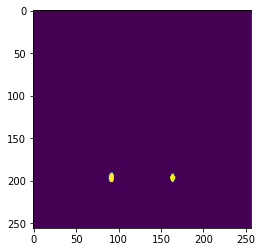

In [ ]:
plt.imshow(predict_imgg[7][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_imgg, y_test):
    # print(count)
    # print(image.shape)
    # print(label.shape)
    dice = dice_coef(label, image)
    # print(dice)
    # print(count)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_imgg)
print("Mean IoU :",m.result().numpy())

dice_average : tf.Tensor(0.4270867, shape=(), dtype=float32)
Mean IoU : 0.5971333


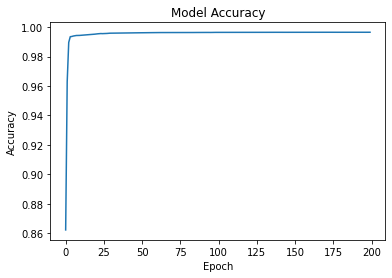

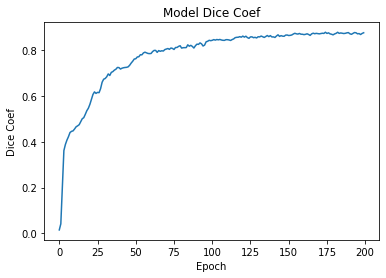

In [ ]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['dice_coef'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['Train','Test'], loc = 'upper left')
plt.show()

# plt.plot(history.history['accuracy'])
plt.plot(history.history['dice_coef'])
plt.title('Model Dice Coef')
plt.ylabel('Dice Coef')
plt.xlabel('Epoch')
#plt.legend(['Train','Test'], loc = 'upper left')
plt.show()